In [1]:
from math import pi
import numpy as np
from scipy import signal 
import matplotlib.pyplot as plt
import wavio
import IPython
import random

In [2]:
def P2R(A, phi):
    return A * ( np.cos(phi) + np.sin(phi) * 1j )

### Method 1:
Repeat the time domain sample.

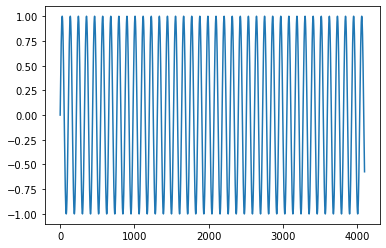

In [3]:
fs = 48000
length = 4096

f = 440.7

time = np.arange(length)
xn = np.sin(2 * np.pi * f * ( time / fs)) 

plt.plot(xn)
plt.show()

wavio.write("OriginalRepeated.wav", np.tile(xn, 40), fs, sampwidth=3)
IPython.display.display(IPython.display.Audio("OriginalRepeated.wav", rate=fs))

### Method 2:
Convert data into frequency domain with random phase.

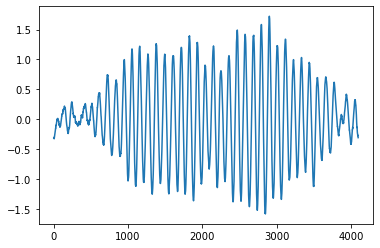

In [4]:
fftSize = length
Sustain = np.fft.fft(xn, fftSize)

randomTemp = np.random.rand(int(fftSize/2 - 1)) * 2 * np.pi - np.pi
randomPhase = np.concatenate(([0], randomTemp, [0], -np.flipud(randomTemp)), axis=0)

LongSustain = P2R(np.abs(Sustain), randomPhase)
longSustain = np.fft.ifft(LongSustain)

plt.plot(longSustain.real)
plt.show()

wavio.write("longSustain.wav", np.tile(longSustain.real, 40), fs, sampwidth=3)
IPython.display.display(IPython.display.Audio("longSustain.wav", rate=fs))

### Method 3:
Convert data into oversample frequency domain with random phase.

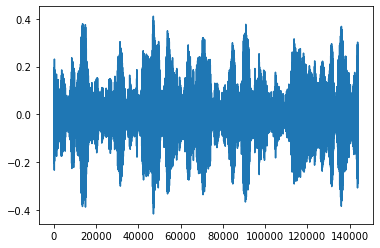

In [5]:
fftSize = fs * 3
Sustain = np.fft.fft(xn, fftSize)

randomTemp = np.random.rand(int(fftSize/2 - 1)) * 2 * np.pi - np.pi
randomPhase = np.concatenate(([0], randomTemp, [0], -np.flipud(randomTemp)), axis=0)

LongSustain = P2R(np.abs(Sustain), randomPhase)
longSustain = np.fft.ifft(LongSustain)

plt.plot(longSustain.real)
plt.show()

wavio.write("longSustainZeroPadding.wav", np.tile(longSustain.real, 4), fs, sampwidth=3)
IPython.display.display(IPython.display.Audio("longSustainZeroPadding.wav", rate=fs))

### Method 4:
Convert data into oversample frequency domain with random phase.

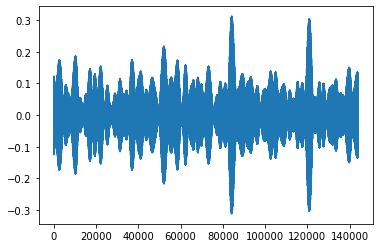

In [6]:
windowedSustain = xn * signal.windows.hann(len(xn))

fftSize = fs * 3
Sustain = np.fft.fft(windowedSustain, fftSize)

randomTemp = np.random.rand(int(fftSize/2 - 1)) * 2 * np.pi - np.pi
randomPhase = np.concatenate(([0], randomTemp, [0], -np.flipud(randomTemp)), axis=0)

LongSustain = P2R(np.abs(Sustain), randomPhase)
longSustain = np.fft.ifft(LongSustain)

plt.plot(longSustain.real)
plt.show()

wavio.write("longSustainPaddingWindow.wav", np.tile(longSustain.real, 4), fs, sampwidth=3)
IPython.display.display(IPython.display.Audio("longSustainPaddingWindow.wav", rate=fs))

In [7]:
def PreProcessData(xn, frameSize, stepSize):
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    data = np.append(np.zeros(frameSize), temp)

    iteration = (len(data) // stepSize) - (frameSize // stepSize) + 1
    
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = data[start:end]
        
    return dataSet, data, len(data), iteration

In [8]:
frameSize = 1024
stepSize = 128

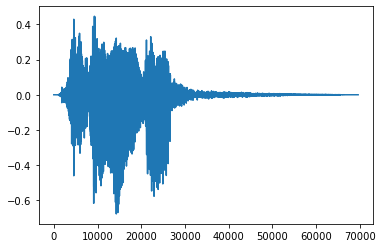

In [9]:
file = wavio.read("china.wav")
fixed_data = file.data[:, 0]
float_data = fixed_data.astype(np.float32, order='C') / 32767.0
dataSet, data, length, iteration = PreProcessData(float_data, frameSize, stepSize)

plt.plot(data)
plt.show()

IPython.display.display(IPython.display.Audio("china.wav", rate = file.rate))

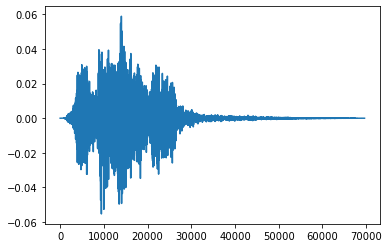

In [10]:
output = np.zeros(length)
fftSize = fs * 3

for i in range(iteration):
    xn = dataSet[i] * signal.windows.hann(frameSize)
    
    Sustain = np.fft.fft(xn, fftSize)
    
    randomTemp = np.random.rand(int(fftSize/2 - 1)) * 2 * np.pi - np.pi
    randomPhase = np.concatenate(([0], randomTemp, [0], -np.flipud(randomTemp)), axis=0)

    LongSustain = P2R(np.abs(Sustain), randomPhase)
    longSustain = np.fft.ifft(LongSustain)
    
    yn = longSustain[:frameSize] * signal.windows.hann(frameSize)
    
    start = i * stepSize
    end = start + frameSize
    
    output[start:end] = output[start:end] + yn.real

plt.plot(output)
plt.show()

wavio.write("output.wav", output, fs, sampwidth=3)
IPython.display.display(IPython.display.Audio("output.wav", rate=fs))